# Modelling notebook - ModelD

This notebook contains two main sections:

1. Data Generation - We used the DataGeneratorSiamese() class for Models A,B and C but, as the data needs to be structured differently for Model D, as it uses triplet loss, we have had to recode and adjust some of the steps.
2. Training model - Defines Model D Embedding Model and subsequent classifier model.
3. Evaluating model on 'Test' data - Evaluates Model D classifier model on test data.

In [46]:
#pip install -U numpy==1.18.5

In [3]:
# Custom functions and setup

from functions_auto import *
import config

# Other packages 

import pandas as pd
import numpy as np
import random
from itertools import combinations
import os 
import config

# Tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import Sequence, plot_model

2022-04-27 14:25:21.311971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# Setting seed
tf.random.set_seed(8)
np.random.seed(8)

In [2]:
#### Download GloveEmbeddings

# - The following code chunk can be used to download the word embeddings, and extracts the correct file from the zip
# - Is included in gitignore so will be kept on your computer

#import urllib.request
#import shutil
#import zipfile
#urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
#shutil.move(config.base_dir+'glove.6B.zip', config.base_dir+'embeddings/glove.6B.zip')
#with zipfile.ZipFile(config.base_dir+'embeddings/glove.6B.zip', 'r') as zfile:
#    unpacked = open(config.base_dir+'embeddings/glove.6B.50d.txt', 'w')
#    unpacked.write(zfile.read('glove.6B.50d.txt').decode('utf-8'))
#    unpacked.close()

## 1. Data Generation

In [5]:
def get_processed_dataset(datasetname):
    return pd.read_csv(config.processed_datasets[datasetname])

df = get_processed_dataset("train_2022_task2")

In [6]:
#Code from: https://github.com/KinWaiCheuk/Triplet-net-keras

testsize = 0.2
trainsize = 1-testsize

triplet_train_pairs = []
triplet_test_pairs = []

#Loop sorts data into triplet pairs based on paragraphs in the same document (or 'problem')
for text in set(df['problem']):
    
    #Subset data to only be dealing with same document
    df1 = df[df['problem'] == text]
    
    #Create lists of row indices
    same_class_idx = np.where((df1['author_1']==df1['author_2']))[0]
    diff_class_idx = np.where((df1['author_1']!=df1['author_2']))[0]
    #Determine k number of samples chosen
    smallest_lst = same_class_idx if len(same_class_idx) < len(diff_class_idx) else diff_class_idx
    k = random.randint(0,len(smallest_lst))
    
    if k > 0 and len(same_class_idx) >2:
        A_P_pairs = random.sample(list(combinations(same_class_idx,2)), k = k)
        Neg_idx = random.sample(list(diff_class_idx), k = k)

        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)

        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = df1['para1_text'].values[ap[0]]
            Positive = df1['para2_text'].values[ap[0]]
            for n in Neg_idx:
                Negative = df1['para2_text'].values[n]
                #the x array for a random negative index
                triplet_train_pairs.append([Anchor,Positive,Negative])   
                
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = df1['para1_text'].values[ap[0]]
            Positive = df1['para2_text'].values[ap[0]]
            for n in Neg_idx:
                Negative = df1['para2_text'].values[n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    

X_train = np.array(triplet_train_pairs) 
X_test = np.array(triplet_test_pairs)

In [7]:
#Create tokenizer and embedding matrix
tokenizer = get_tokenizer(df, max_words=10000)
embed_matrix = get_embed_matrix(tokenizer, embedding_dim=50)

Found 400000 word vectors.
Loaded 400000 word vectors.
(10001, 50)


In [9]:
max_len = 300

#Creating training data
Anchor = tokenizer.texts_to_sequences(X_train[:,0])
Anchor = pad_sequences(Anchor, maxlen=max_len, padding='post')

Positive = tokenizer.texts_to_sequences(X_train[:,1])
Positive = pad_sequences(Positive, maxlen=max_len, padding='post')

Negative = tokenizer.texts_to_sequences(X_train[:,2])
Negative = pad_sequences(Negative, maxlen=max_len, padding='post')

#Creating validation data
Anchor_val = tokenizer.texts_to_sequences(X_test[:,0])
Anchor_val = pad_sequences(Anchor_val, maxlen=max_len, padding='post')

Positive_val = tokenizer.texts_to_sequences(X_test[:,1])
Positive_val = pad_sequences(Positive_val, maxlen=max_len, padding='post')

Negative_val = tokenizer.texts_to_sequences(X_test[:,2])
Negative_val = pad_sequences(Negative_val, maxlen=max_len, padding='post')

# need to feed a Y into model.fit (and model.evaluate)
Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_val.shape[0],1))


In [10]:
# Defining accuracy because we want to 
#Code from: https://github.com/noelcodella/tripletloss-keras-tensorflow/blob/master/tripletloss.py
def accuracy(y_true, y_pred):
    '''
    loss[i] = 1 if y_pred[i, 0] < y_pred[i, 1] else 0
    '''
    return K.mean(y_pred[:,0] < y_pred[:,1])

def triplet_loss(y_true, y_pred):
    margin = K.constant(1)
    return K.mean(K.maximum(K.constant(0), K.square(y_pred[:,0]) - 0.5*(K.square(y_pred[:,1])+K.square(y_pred[:,2])) + margin))

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


## 2. Training model

### *Training embedding network*

This section creates and trains a network based on triplet loss.

In [29]:
def create_base_network(embedding_dim, max_len, embed_matrix):
    """
    Base network to be shared.
    """
    model = Sequential()
    embeddings_initializer = Constant(embed_matrix)
    model.add(Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True))
    model.add(Bidirectional(LSTM(100, dropout=0.2)))
    
    return model

In [30]:
# Initialises model and shows summary of model
#Code from: https://github.com/noelcodella/tripletloss-keras-tensorflow/blob/master/tripletloss.py
adam_optim = Adam(clipnorm=1.5)

anchor_input = Input((max_len, ), name='anchor_input')
positive_input = Input((max_len, ), name='positive_input')
negative_input = Input((max_len, ), name='negative_input')

Shared_DNN = create_base_network(embedding_dim = 50, max_len=300, embed_matrix=embed_matrix)

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)

positive_dist = Lambda(euclidean_distance, name='pos_dist')([encoded_anchor, encoded_positive])
negative_dist = Lambda(euclidean_distance, name='neg_dist')([encoded_anchor, encoded_negative])
tertiary_dist = Lambda(euclidean_distance, name='ter_dist')([encoded_positive, encoded_negative])

# This lambda layer simply stacks outputs so both distances are available to the objective
stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([positive_dist, negative_dist, tertiary_dist])

model = Model([anchor_input, positive_input, negative_input], stacked_dists, name='triple_siamese')

model.compile(loss=triplet_loss, optimizer=adam_optim, metrics=[accuracy])

model.summary()

Model: "triple_siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 300)]        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          620850      anchor_input[0][0]               
                                                                 positive_input[0][0]

In [31]:
#Creating checkpoints
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*1000, # Approx every 5 epoch
    #save_freq=5*BATCH_SIZE
    )

model.save_weights(checkpoint_path.format(epoch=0))
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
#Fitting model
history = model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_val,Positive_val,Negative_val],Y_dummy2), batch_size=64, epochs=100, callbacks=[cp_callback,stop_callback])

Epoch 1/100
78/78 [==============================] - 15s 119ms/step - loss: 0.9853 - accuracy: 0.5091 - val_loss: 0.9591 - val_accuracy: 0.5181
Epoch 2/100
78/78 [==============================] - 8s 101ms/step - loss: 0.8121 - accuracy: 0.5948 - val_loss: 0.8977 - val_accuracy: 0.5708
Epoch 3/100
78/78 [==============================] - 8s 101ms/step - loss: 0.6714 - accuracy: 0.6644 - val_loss: 0.8625 - val_accuracy: 0.5980
Epoch 4/100
78/78 [==============================] - 8s 101ms/step - loss: 0.5389 - accuracy: 0.7232 - val_loss: 0.8590 - val_accuracy: 0.6078
Epoch 5/100
78/78 [==============================] - 8s 101ms/step - loss: 0.4657 - accuracy: 0.7690 - val_loss: 0.8430 - val_accuracy: 0.6264
Epoch 6/100
78/78 [==============================] - 8s 101ms/step - loss: 0.3892 - accuracy: 0.7978 - val_loss: 0.8295 - val_accuracy: 0.6468
Epoch 7/100
78/78 [==============================] - 8s 101ms/step - loss: 0.3190 - accuracy: 0.8218 - val_loss: 0.8379 - val_accuracy: 0.641

In [45]:
#model.save('modelD_latest')

<AxesSubplot:>

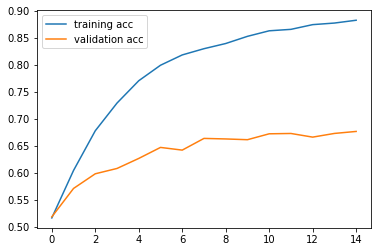

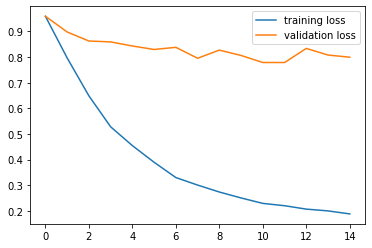

In [34]:
acc = pd.DataFrame({"training acc":history.history['accuracy'],
                            "validation acc": history.history['val_accuracy']})
acc.plot()

loss = pd.DataFrame({"training loss":history.history['loss'],
                            "validation loss": history.history['val_loss']})
loss.plot()

### *Training embedding network*

Given that to evaluate our testing data we need a model which takes pairs of paragraphs rather than triplets of paragraphs, in the code below we train a classifier model based on the generated distances between the positive/anchor and positive/negative pairs.

In [36]:
#Runs the original embed matrices through the base model and stacks the results to be used as inputs for the
#classifier.

#Stacks positive trained embeddings on top of each other as positive will be compared to both negative and anchor
x_train_input1 = np.vstack([Shared_DNN.predict(Positive),Shared_DNN.predict(Positive)])
x_train_input1_val = np.vstack([Shared_DNN.predict(Positive_val),Shared_DNN.predict(Positive_val)])
#Stacks negative training embeddings and then anchor trained embeddings as both will be compared to positive
x_train_input2 = np.vstack([Shared_DNN.predict(Negative),Shared_DNN.predict(Anchor)])
x_train_input2_val = np.vstack([Shared_DNN.predict(Negative_val),Shared_DNN.predict(Anchor_val)])

# Calculates euclidean distance between each paired row of the two vectors
total_input = euclidean_distance([x_train_input1,x_train_input2])
total_input_val = euclidean_distance([x_train_input1_val,x_train_input2_val])

In [37]:
#Creates y array for training the classifier
y_binary = np.vstack([np.full((Positive.shape[0],1), 1), np.full((Positive.shape[0],1), 0)])
y_binary_val = np.vstack([np.full((Positive_val.shape[0],1), 1), np.full((Positive_val.shape[0],1), 0)])

In [38]:
# Defining classifier that computes the class of a specific distance
#Code from https://github.com/sauravjoshi23/SiameseNet-Loss/blob/master/siamese-triplet-loss.ipynb
classifier_input = Input(shape=(1,))
classifier_hidden = Dense(100, activation='sigmoid')(classifier_input)
classifier_output = Dense(1, activation='sigmoid')(classifier_hidden)
classifier_model = Model(classifier_input, classifier_output)

In [39]:
# Fitting classifier
classifier_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_m])
classifier_model.fit(x=total_input,y=y_binary,validation_data= (total_input_val,y_binary_val) , epochs=10)

Epoch 1/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6588 - accuracy: 0.7546 - f1_m: 0.7942 - val_loss: 0.6284 - val_accuracy: 0.6872 - val_f1_m: 0.4458
Epoch 2/10
311/311 [==============================] - 1s 3ms/step - loss: 0.4645 - accuracy: 0.9103 - f1_m: 0.9042 - val_loss: 0.6527 - val_accuracy: 0.6745 - val_f1_m: 0.4623
Epoch 3/10
311/311 [==============================] - 1s 3ms/step - loss: 0.3494 - accuracy: 0.9105 - f1_m: 0.9047 - val_loss: 0.6878 - val_accuracy: 0.6838 - val_f1_m: 0.4529
Epoch 4/10
311/311 [==============================] - 1s 3ms/step - loss: 0.3016 - accuracy: 0.9105 - f1_m: 0.9046 - val_loss: 0.8163 - val_accuracy: 0.6662 - val_f1_m: 0.4686
Epoch 5/10
311/311 [==============================] - 1s 3ms/step - loss: 0.2949 - accuracy: 0.9074 - f1_m: 0.9028 - val_loss: 0.8458 - val_accuracy: 0.6694 - val_f1_m: 0.4662
Epoch 6/10
311/311 [==============================] - 1s 3ms/step - loss: 0.2853 - accuracy: 0.9086 - f1_m: 0.9031 - val

## 3. Testing model

In [40]:
# Initialising test data
df_test = get_processed_dataset('valid_2022_task2')

In [41]:
#Creating y variable
df_test['same_author'] = df_test.apply(lambda x:  1 if x['author_1'] != x['author_2'] else 0, axis=1)

In [42]:
#Tokenizing both sets of paragraphs
x_test1 = tokenizer.texts_to_sequences(df_test['para1_text'])
x_test1 = pad_sequences(x_test1, maxlen=max_len, padding='post')
x_test2 = tokenizer.texts_to_sequences(df_test['para2_text'])
x_test2 = pad_sequences(x_test2, maxlen=max_len, padding='post')

In [43]:
#Runs the original embed matrices through the base model and calculates the distance between each pair of paragraphs.
total_input_test = euclidean_distance([Shared_DNN(x_test1),Shared_DNN(x_test2)])

2022-04-27 14:35:34.749694: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 572220000 exceeds 10% of free system memory.
2022-04-27 14:35:35.489594: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 572220000 exceeds 10% of free system memory.


In [44]:
#Evaluates the testing data
classifier_model.evaluate(total_input_test, df_test['same_author'])

299/299 [==============================] - 1s 2ms/step - loss: 1.0202 - accuracy: 0.6053 - f1_m: 0.7135


[1.0201764106750488, 0.6053265929222107, 0.7135379314422607]